# Gradient Boosting Machine(GBM)

## GBM 회귀모델
- GBM은 𝑚라운드의 베이스 모델 $ℎ_𝑚$ 이 $(m-1)$라운드까지의 베이스 모델을 결합한 $𝐻𝑚−1=ℎ_1+⋯+ℎ_{𝑚−1}$의 예측 오류를 학습하는 알고리즘
- 즉, 이전 결합 모델 $H_{m-1}$의 예측 오류는 예측 불가능한 랜덤 노이즈가 아닌 아직까지 학습 못한 특징이라고 가정함
- 베이스모델로는 의사결정나무 알고리즘인 **CART**를 주로 사용
- $h_0$는 초기값으로 일반적으로 회귀문제에서 출력변수의 평균을 사용함. 실질적으로 $h_1$ 부터 베이스 모델을 학습시킴

![](img\gbm회귀.png)

### 1. 데이터 로드 및 전처리

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib
#한글꺠짐 방지
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
data=pd.read_csv("./data/Fault_data.csv",encoding="EUC-KR")
data.drop(["자재구분","END_DATE_TIME"],axis=1,inplace=True)
data.dropna(axis=1,inplace=True)

#X,Y 분할
Y=data["Y"].copy()
X=data.drop("Y",axis=1)
X.head(3)

,CHAMBER,TAE.STDDEV0,TAE.MEAN0,TAE.RANGE0,PC.STDDEV0,PC.MEAN0,PC.RANGE0,CROT.STDDEV0,CROT.MEAN0,CROT.RANGE0,...,PC.RANGE12,TAE.STDDEV9,TAE.MEAN9,TAE.RANGE9,CROT.STDDEV9,CROT.MEAN9,CROT.RANGE9,PC.STDDEV9,PC.MEAN9,PC.RANGE9
0,4,0.044554,38.083127,0.254154,0.124753,0.044329,0.439883,0,35,0,...,17.350926,0.032832,35.011650,0.127077,0,35,0,0.405343,45.124841,3.079182
1,2,0.034801,38.052395,0.063538,0.177575,0.342131,0.439883,0,27,0,...,1.466280,0.020858,35.550245,0.063540,0,27,0,1.923012,45.350277,15.004887
2,3,0.030089,38.046407,0.127080,0.137559,0.063983,0.488759,0,15,0,...,13.098728,0.021635,36.013373,0.063538,0,15,0,0.161640,45.071393,0.977516


### 2. 평가 지표 함수

In [4]:
# 평가 지표 출력 함수
def print_all_reg(Y_test,pred):
    print("model의 MSE 값은 {:.3f}".format(mean_squared_error(Y_test,pred)))
    print("model의 MAE 값은 {:.3f}".format(mean_absolute_error(Y_test, pred)))
    print("model의 MAPE 값은 {:.3f}".format(mean_absolute_percentage_error(Y_test, pred)))
    print("model의 r2 값은 {:.3f}".format(r2_score(Y_test, pred)))

### 3. 모델 학습 및 예측

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5,shuffle =True)

[[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)]  
**sklearn.model_selection.train_test_split**
- **test_size** : float or int, default = 0.25, 정수값일시 test사이즈로 설정하고 싶은 샘플 수 입력
- **train_size** : float or int, default = None
- **random_state** : int, default = None, 랜덤 seed값 설정, 같은 seed 내에선 동일결과 추출 
- **shuffle** : bool, default = True, 데이터셋 무작위 추출, 시계열 데이터와 같이 순차적 추출이 필요한 경우엔 Shuffle = False!
- **stratify** : array-like, default = None, True일시 계층적 샘플링 진행 ([참고](https://www.investopedia.com/terms/stratified_random_sampling.asp))

[[GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)]         
**주요 하이퍼파라미터** 
- **loss** : {‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}, default=’squared_error’, 경사하강법을 활용한 예측오류 학습과정에서 사용할 손실함수 
- **learning_rate** : float, default=0.1, 학습률 설정
    - 너무 작을시 : 예측성능은 높아질 수 있으나, 학습시간이 오래걸리고 local minima 문제가 발생 할 수 있음. 베이스 모델의 영향력이 과도하게 수축되어 과소적합
    - 너무 클 시 : 학습속도가 빠르지만 global mimimum값을 찾지 못할 수 있으며, 베이스 모델 영향력이 과도하게 커져 과적합이 나타남.
- **n_estimators** : int, default=100, 베이스모델의 개수로 많을수록 예측성능은 높아질 수 있으나 학습시간이 오래걸린다.
- **max_depth** : int, default = 3, 각 트리의 최대깊이를 설정. 값이 클수록 모델의 복잡도가 올라간다.
- **min_samples_split** : int or float, default = 2, 자식노드를 분할하는데 필요한 최소 샘플의 수
- **min_samples_leaf** : int or float, default = 1, leaf node에서 필요한 최소 샘풀수이며, 너무 적을 시 과적합 발생
- **max_leaf_nodes** : int, default=None, 최대 leaf node 수 제한
- **validation_fraction** : float, default=0.1, 훈련데이터 중 설정 비율만큼 검증용 데이터셋으로 활용한다. 
- **n_iter_no_change** : int, default=None, validation_fraction에서 설정한 검증데이터셋에서 n_iter_no_change에 지정한 반복 횟수동안 검증점수가 좋아지지 않으면 학습을 조기종료한다.
- **ccp_alpha** : non-negative float, default=0.0

In [12]:
from sklearn.tree import DecisionTreeRegressor
#ccp_alpha_list = list(np.arange(0.1,1,0.1)) # 0.1부터 0.9까지 0.1 간격으로 출력한 값을 리스트로 반환
ccp_alpha_list = [0.002,0.01,0.8]

train_scores =[]
test_scores =[]
for alpha in ccp_alpha_list: # 사전 정의한 리스트의 각 값마다 모델을 학습하여 최적값 도출
    print(alpha)
    clf = GradientBoostingRegressor(random_state=5,n_estimators = 500,learning_rate = alpha
                                    #,min_samples_leaf = 2,min_samples_split = 2
                                    ,validation_fraction = 0.2, n_iter_no_change = 20,
                                    ccp_alpha = 50
                                   ) # ccp_alpha 값보다 작으면서 비용복잡도가 가장 큰 Subtree로 GBM모델 학습
    clf.fit(X_train,Y_train) # 정의한 GBM 모델로 훈련데이터 학습
    
    preds_train = clf.predict(X_train) # 훈련데이터로 학습한 모델로 y값 예측
    preds = clf.predict(X_test) # 실제 테스트 데이터로 y값 예측
    
    train_scores.append(mean_absolute_error(Y_train,preds_train)) # 훈련 성능 평가
    test_scores.append(mean_absolute_error(Y_test,preds)) # 테스트 성능 평가
    
    print_all_reg(preds_train,Y_train) # 평가지표 출력
    print("")
    print_all_reg(preds,Y_test)

0.002
model의 MSE 값은 1390.370
model의 MAE 값은 28.010
model의 MAPE 값은 0.385
model의 r2 값은 -0.086

model의 MSE 값은 1007.474
model의 MAE 값은 26.093
model의 MAPE 값은 0.390
model의 r2 값은 0.082
0.01
model의 MSE 값은 807.393
model의 MAE 값은 19.946
model의 MAPE 값은 0.310
model의 r2 값은 0.667

model의 MSE 값은 1062.268
model의 MAE 값은 24.389
model의 MAPE 값은 0.374
model의 r2 값은 0.457
0.8
model의 MSE 값은 862.699
model의 MAE 값은 17.451
model의 MAPE 값은 0.307
model의 r2 값은 0.774

model의 MSE 값은 2636.273
model의 MAE 값은 32.912
model의 MAPE 값은 0.474
model의 r2 값은 0.370


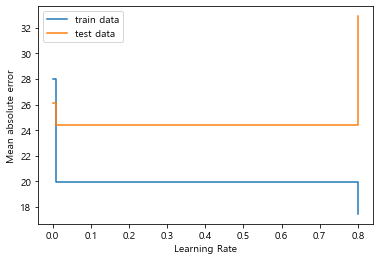

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Mean absolute error")
#ax.set_title("나무 복잡도 증가에 따른 오분류율 그래프")
ax.plot(ccp_alpha_list, train_scores,  label="train data", drawstyle="steps-post")
ax.plot(ccp_alpha_list, test_scores,  label="test data", drawstyle="steps-post")

#ax.plot(ccp_alpha_list, train_scores, drawstyle="steps-post")
#ax.plot(ccp_alpha_list, test_scores, drawstyle="steps-post")

ax.legend()
#plt.xlim(0.7)
plt.show()
plt.close('all')